# 

# Building an OCR from scratch

So in this tutorial, I will give you a basic code walkthrough for building a simple OCR. OCR as might know stands for optical character recognition or in layman terms it means text recognition. Text recognition is one of the classic problems in computer vision and is still relevant today. One of the most important applications of text recognition is the digitization of old manuscripts. Physical copies of books and manuscripts are prone to degradations. With time, the printed characters start to fade. On simple way to preserve such documents is to make a digital copy of it and store it in the cloud or local hard drive which would ensure their continuance. Similarly, text recognition can also be used for licence plate recognition and can also be used in forensics in terms of handwriting recognition. 

Okay, now that I have given you enough motivation as to why OCR is important, let me show you how you can build one. 
So first things first, I'll start with listing down some of the essential packages that you would need to build your first OCR. We will be working with PyTorch as it is one of the most efficient deep learning libraries present. The other packages are as follows:

* Pytorch 1.5
* Matplotlib
* Tqdm
* textdistance
* lmdb

You can install them either via a pip or conda. I will also be providing a requirements.txt file which you can find in my Github repo. Do a simple `pip install -r requirements` and you are set to go.

## Setting up the Data

We will start our project by importing the libraries. But before that we need data. Now, you are free to use any text image data you might like and for that, you might need to build your own data loader. However, in the interest of keeping things simple, we will be using a neat little package called `trdg`, which is a synthetic image generator for OCR. You can find all the relevant information regarding this package on its [github repository](https://github.com/Belval/TextRecognitionDataGenerator). You can generate printed as well as hand-written text images and infuse them with different kinds of noise and degradation. In this project, I have used trdg to generate printed word images of a single font. You can use any font you like. Just download a `.ttf` file for your font and while generating the word images be sure to specify the `-ft` parameter as your font file. 

You can generate the word images for training using the following commands:

`trdg -i words.txt -c 20000 --output_dir data/train -ft your/fontfile`

ATENTION: Run this one instead `trdg -i words.txt -c 20000 --output_dir data/train -fd fonts/`

Here, `-c` refers to the number of word images you want to generate. `words.txt` file contains our input word vocabulary while `--output_dir` and `-ft` refer to the output and font file respectively. You can similarly generate the test word images for evaluating the performance of your OCR. However, ensure that words for training and testing are mutually exclusive to each other.

Okay, now that we have generated the word images, let us display a few images using matlplotlib
%# TODO diplay images from folder

Now lets start importing the libraries that we would need to build our OCR

In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *

# added
import xmltodict
from sklearn.metrics import precision_score, recall_score

Next, let us create our data pipe-line. We do this by inheriting the PyTorch Dataset class. The Dataset class has few methods that we need to adhere to like the `__len__` and `__getitem__` method. The `__len__` method returns the number of items in our dataset while `__getitem_` returns the data item for the index passed. You can find more information on PyTorch Dataset class on PyTorch's official documentation page. 

You will observe that we first convert each image into grayscale and convert it into a tensor. This is followed by normalizing the images so that our input data lies within a range of [-1, 1]. We pass all such transformations into a list and later call the transforms to compose function provided by PyTorch. The transform Compose function applies each transformation in the pre-defined order.

In [17]:
# New dataloader - CarPlatesDataset
# Both __init__ and __len__ methods remain the same
class CarPlatesDataset(Dataset):
    
    def __init__(self, opt):
        super(CarPlatesDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.images = os.listdir(self.path)
        self.annotations_dir = os.path.join(opt['path'], opt['annotations_dir']) #added
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
       	transform_list =  [transforms.Grayscale(1),
                           transforms.Resize((opt['image_size'][0], opt['image_size'][1])), #added
                           transforms.ToTensor(), 
                           transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        imagefile = imagefile.split('.')[0]

        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)

        # 'annotations' is the path to the XML files. 
        # We open the file, read it and convert the data into a dictionary.
        # Then we go through each object in the xml data, extract the name field, and add it to a list (labels). 
        # We combine the labels from the list into a single string and, finally, return a dictionary with the image, index, and label.
        annotations = os.path.join(self.annotations_dir, imagefile + '.xml')
        labels = []
        try:
            with open(annotations, 'r') as file:
                data_dict = xmltodict.parse(file.read())
            for item in data_dict['annotation']['object']:
                name = item['name']
                labels.append(name)
        except (xmltodict.expat.ExpatError, FileNotFoundError):
            print(f"Error while parsing {annotations}.")

        label = ''.join(labels)
        
        item = {'img': img, 'idx': index, 'label': label}
        return item

In [18]:
dataset = CarPlatesDataset(args)

In [19]:
dataset.__getitem__(1)

{'img': tensor([[[-0.0431, -0.0824, -0.1686,  ..., -0.8902, -0.8980, -0.8980],
          [-0.0431, -0.0353, -0.0275,  ..., -0.7961, -0.7569, -0.7098],
          [-0.1294, -0.1059, -0.1059,  ..., -0.1765, -0.1529, -0.1294],
          ...,
          [-0.9686, -0.9765, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9608, -0.9608, -0.9686],
          [-0.9608, -0.9686, -0.9686,  ..., -0.9608, -0.9608, -0.9765]]]),
 'idx': 1,
 'label': 'MH2OBN3525'}

Next, since we are going to train our model using the mini-batch gradient descent, it is essential that each image in the batch is of the same shape and size. For this, we have defined the `SynthCollator` class which initially finds the image with maximum width in the batch and then proceeds to pad all images to have the same width. 

In [20]:
class SynthCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

## Defining our Model

Now we proceed to define our model. We use the CNN-LSTM based architecture which was proposed by Shi et.al. in their excellent paper [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf). The authors used it for scene-text recognition and showed via extensive experimentation that they were able to achieve significant gains in accuracy compared to all other existing methods at that time.


<img src="images/crnn.png" alt="drawing" width="400"/>

The figure above shows the architecture used in the paper. The authors used a 7 layered Convolution network with BatchNorm and ReLU. This was followed by a stacked RNN network consisting of two Bidirectional LSTM layers. The convolution layers acted as a feature extractor while the LSTMs layers act as sequence classifiers. The LSTM layers output the probability associated with each output class at each time step
Further details can be found in their paper and I strongly suggest you go through it for a better understanding.

The below code snippet is taken from this [github repository](https://github.com/meijieru/crnn.pytorch) which provides a Pytorch implementation of their code.


In [21]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

## The CTC Loss 

Okay, now that we have our data and model pipeline ready, it is time to define our loss function which in our case is the CTC loss function. We will be using PyTorch's excellent CTC implementation. CTC stands for Connectionist Temporal Classification and was proposed by Alex Graves in his paper [Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks](https://www.cs.toronto.edu/~graves/icml_2006.pdf). 

Honestly, the above work has been a gamechanger for many sequences based tasks like speech and text recognition. For all the sequence-based tasks it is important for the input and output labels to be properly aligned. Proper alignment leads to efficient loss computation between the network predictions and expected output. In segmentation based approaches i.e. when the input word or line has been segmented into its constituent characters, there exists a direct one-to-one mapping between the segmented images of characters and the output labels.  However, as you might imagine obtaining such segmentations for each character can be a very tedious and time-consuming task. Thus, CTC based transcription layers have become the de-facto choice for OCRs and speech recognition module since it allows loss computation without explicit mapping between the input and output. The CTC layer takes the output from the LSTMs and computes a score with all possible alignments of the target label. The OCR is then trained to predict a sequence which maximizes the sum of all such scores.

If you want more thorough details regarding the CTC layer I would suggest you go through the following blogs and lecture video

* [CMU Deep Learning Course Lecture 14](https://www.youtube.com/watch?v=c86gfVGcvh4&t=670s)
* [Sequence Labelling with CTC](https://distill.pub/2017/ctc)

In [22]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

## The Training Loop

The above code snippet builds a wrapper around pytorch's CTC loss function. Basically, what it does is that it computes the loss and passes it through an additional method called `debug`, which checks for instances when the loss becomes Nan. 

Shout out to [Jerin Philip](https://jerinphilip.github.io/) for this code.

Now, let us come to the training loop. The below code might look a bit cumbersome but it provides a nice abstraction which is quite intuitive and easy to use. The below code is based on [pytorch lighning](https://github.com/PyTorchLightning/pytorch-lightning)'s bolier plate template with few modifications of my own. :P

I will give a basic overview of what it does. Feel free to inspect each method using python debugger. So, the `OCRTrainer` class takes in the training and validation data. It also takes in the loss function, optimizer and the number of epoch it needs to train the model. The train and validation loader method returns the data loader for the train and validation data. the `run_batch` method does one forward pass for a batch of image-label pairs. It returns the loss as well as the character and word accuracy. Next, we have the step functions which does the backpropagation, calculates the gradient and updates the parameters for each batch of data. Besides we also have the `training_end` and `validation_end` methods that calculate the mean loss and accuracy for each batch after the completion of one single epoch

All, the methods defined are quite simple and I hope you will get the hang of it in no time.

In [23]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

## Putting Everything Together

And, finally, we have the `Learner` class. It implements a couple of more methods like the `save` and `load` model. It also tracks the losses and saves them in a `csv` file. This comes in handy if we want to analyze the behaviour of our training and validation loops. It initializes our `OCRTrainer` module with the necessary hyperparameters and later calls the `fit` method which runs the training loop.

Besides these methods, we have a bunch of helper methods like the `OCRLabel_converter`, `Eval` and `Averagemeter`. I am not including them in this notebook, instead, I have written them in utils.py file and I am importing them from there. In case you want to take a peek, feel free to tinker with the utils.py file. All the necessary documentation is provided in the file itself.

In [24]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        #self.model.load_state_dict(self.checkpoint['state_dict'])
        self.model.load_state_dict(self.checkpoint['state_dict'], strict=False)
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            #self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'], strict=False)

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

### Defining the hyperparameters

Okay, now that we have set the premise, its time to unfold the drama. We begin by defining our vocabulary i.e. the alphabets which serve as the output classes for our model.
We define a suitable name for this experiment which will also serve as the folder name where the checkpoints and log files will be stored. We also define the hyper-parameters like the batch size, learning rate, image height, number of channels etc.

Then we initialize our Dataset class and split the data into train and validation. We then proceed to initialize our Model and CTCLoss and finally call the `learner.fit` function.

Once the training is over we can find the saved model in the `checkpoints/name` folder. We may load the model and evaluate its performance on the test data or finetune it on some other data.

In [20]:
!export CUDA_VISIBLE_DEVICE=3

In [14]:
print(torch.cuda.current_device())

0


In [21]:
torch.cuda.current_device()

0

In [17]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [29]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp1',
    'path':'/home/guscarrian@GU.GU.SE/LT2326-ML/A1/Adapting-OCR/carplates_dataset/LP-characters',
    'imgdir': 'train_images',
    'annotations_dir': 'annotations',
    'image_size': (32, 168), #added
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':150, #150 #original 4
    'batch_size':32, #128 #original 32
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':False,
    'schedule':False
}

data = CarPlatesDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:133
Val Data Size:34
Let's use 4 GPUs!
checkpoint does not exist
None
Scheduling is False


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.22it/s, val_loss=4.06, val_ca=0, val_wa=0]


4.072951555252075
Validation loss decreased (inf --> 4.072952).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  7.26it/s, val_loss=3.51, val_ca=0, val_wa=0]


3.811334013938904
Validation loss decreased (4.072952 --> 3.811334).  Saving model ...


Validating: 100%|████████████████████| 2/2 [00:00<00:00,  5.76it/s, val_loss=3.5, val_ca=0, val_wa=0]


3.705883502960205
Validation loss decreased (3.811334 --> 3.705884).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.59it/s, val_loss=3.47, val_ca=0, val_wa=0]


3.642828792333603
Validation loss decreased (3.705884 --> 3.642829).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.32it/s, val_loss=3.39, val_ca=0, val_wa=0]


3.5927974700927736
Validation loss decreased (3.642829 --> 3.592797).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.36it/s, val_loss=3.38, val_ca=0, val_wa=0]


3.553904036680857
Validation loss decreased (3.592797 --> 3.553904).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  4.40it/s, val_loss=3.29, val_ca=0, val_wa=0]


3.5165240594318936
Validation loss decreased (3.553904 --> 3.516524).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=3.51, val_ca=0, val_wa=0]


3.517839163541794
EarlyStopping counter: (-3.516524 1 out of 15)


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 12.33it/s, val_loss=3.25, val_ca=0, val_wa=0]


3.485532588428921
Validation loss decreased (3.516524 --> 3.485533).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.45it/s, val_loss=3.19, val_ca=5, val_wa=0]


3.4546441435813904
Validation loss decreased (3.485533 --> 3.454644).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.28it/s, val_loss=3.14, val_ca=5, val_wa=0]


3.4268910017880527
Validation loss decreased (3.454644 --> 3.426891).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 12.68it/s, val_loss=3.13, val_ca=5, val_wa=0]


3.401154319445292
Validation loss decreased (3.426891 --> 3.401154).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.83it/s, val_loss=3.04, val_ca=10, val_wa=0]


3.375106793183547
Validation loss decreased (3.401154 --> 3.375107).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.40it/s, val_loss=3.04, val_ca=10, val_wa=0]


3.3517309853008816
Validation loss decreased (3.375107 --> 3.351731).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.23it/s, val_loss=3.02, val_ca=10, val_wa=0]


3.329779616991679
Validation loss decreased (3.351731 --> 3.329780).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.09it/s, val_loss=3.03, val_ca=10, val_wa=0]


3.313233822584152
Validation loss decreased (3.329780 --> 3.313234).  Saving model ...


Epoch: [15]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.19it/s, loss=3.03, train_ca=10.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.22it/s, val_loss=3.01, val_ca=10, val_wa=0]


3.2959277559729183
Validation loss decreased (3.313234 --> 3.295928).  Saving model ...


Epoch: [16]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.21it/s, loss=3.01, train_ca=5.43, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.85it/s, val_loss=2.98, val_ca=5, val_wa=0]


3.279027031527625
Validation loss decreased (3.295928 --> 3.279027).  Saving model ...


Epoch: [17]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.99it/s, loss=2.71, train_ca=4.44, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.23it/s, val_loss=2.95, val_ca=10, val_wa=0]


3.262875324801395
Validation loss decreased (3.279027 --> 3.262875).  Saving model ...


Epoch: [18]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.09it/s, loss=2.96, train_ca=4.22, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.89it/s, val_loss=2.98, val_ca=0, val_wa=0]


3.2507664024829865
Validation loss decreased (3.262875 --> 3.250766).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=2.97, val_ca=10, val_wa=0]


3.236269610268729
Validation loss decreased (3.250766 --> 3.236270).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=2.86, val_ca=5, val_wa=0]


3.219693427736109
Validation loss decreased (3.236270 --> 3.219693).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.21it/s, val_loss=2.89, val_ca=5, val_wa=0]


3.2092579810515693
Validation loss decreased (3.219693 --> 3.209258).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.03it/s, val_loss=2.86, val_ca=5, val_wa=0]


3.1946192930142083
Validation loss decreased (3.209258 --> 3.194619).  Saving model ...


Epoch: [23]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.35it/s, loss=3.39, train_ca=10.5, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00, 10.88it/s, val_loss=2.84, val_ca=5, val_wa=0]


3.1808556175231932
Validation loss decreased (3.194619 --> 3.180856).  Saving model ...


Epoch: [24]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.03it/s, loss=2.71, train_ca=10.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.09it/s, val_loss=2.78, val_ca=10, val_wa=0]


3.1667906045913696
Validation loss decreased (3.180856 --> 3.166791).  Saving model ...


Epoch: [25]/[150] Training: 100%|█| 5/5 [00:01<00:00,  4.79it/s, loss=3.22, train_ca=4.22, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.04it/s, val_loss=2.76, val_ca=10, val_wa=0]


3.153202427758111
Validation loss decreased (3.166791 --> 3.153202).  Saving model ...


Epoch: [26]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.23it/s, loss=2.67, train_ca=10.5, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.92it/s, val_loss=2.77, val_ca=0, val_wa=0]


3.140712342091969
Validation loss decreased (3.153202 --> 3.140712).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.88it/s, val_loss=2.81, val_ca=5, val_wa=0]


3.129272226629586
Validation loss decreased (3.140712 --> 3.129272).  Saving model ...


Epoch: [28]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.09it/s, loss=2.56, train_ca=16.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.62it/s, val_loss=2.73, val_ca=10, val_wa=0]


3.1177042524019876
Validation loss decreased (3.129272 --> 3.117704).  Saving model ...


Epoch: [29]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.14it/s, loss=2.84, train_ca=16.2, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.06it/s, val_loss=2.78, val_ca=5, val_wa=0]


3.1076052688783213
Validation loss decreased (3.117704 --> 3.107605).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.37it/s, val_loss=2.74, val_ca=0, val_wa=0]


3.09759633615613
Validation loss decreased (3.107605 --> 3.097596).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.86it/s, val_loss=2.86, val_ca=5, val_wa=0]


3.0915462826237534
Validation loss decreased (3.097596 --> 3.091546).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.25it/s, val_loss=2.76, val_ca=5, val_wa=0]


3.0825213825001434
Validation loss decreased (3.091546 --> 3.082521).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.55it/s, val_loss=2.81, val_ca=0, val_wa=0]


3.075782700947353
Validation loss decreased (3.082521 --> 3.075783).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  4.64it/s, val_loss=2.76, val_ca=10, val_wa=0]


3.068105571799808
Validation loss decreased (3.075783 --> 3.068106).  Saving model ...


Epoch: [35]/[150] Training: 100%|█| 5/5 [00:00<00:00,  5.83it/s, loss=2.52, train_ca=10.7, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 10.51it/s, val_loss=2.74, val_ca=10, val_wa=0]


3.0624335231007755
Validation loss decreased (3.068106 --> 3.062434).  Saving model ...


Epoch: [36]/[150] Training: 100%|█| 5/5 [00:00<00:00,  5.65it/s, loss=2.75, train_ca=20.2, train_wa=0
Validating: 100%|████████████████████| 2/2 [00:00<00:00, 10.37it/s, val_loss=2.8, val_ca=5, val_wa=0]


3.0571491875146566
Validation loss decreased (3.062434 --> 3.057149).  Saving model ...


Epoch: [37]/[150] Training: 100%|█| 5/5 [00:00<00:00,  5.62it/s, loss=2.94, train_ca=12.4, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.13it/s, val_loss=2.96, val_ca=0, val_wa=0]


3.056504188439785
Validation loss decreased (3.057149 --> 3.056504).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 12.65it/s, val_loss=2.84, val_ca=5, val_wa=0]


3.050396743416786
Validation loss decreased (3.056504 --> 3.050397).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.96it/s, val_loss=2.7, val_ca=10, val_wa=0]


3.046404818209206
Validation loss decreased (3.050397 --> 3.046405).  Saving model ...


Epoch: [40]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.60it/s, loss=2.95, train_ca=14.5, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.86it/s, val_loss=2.74, val_ca=0, val_wa=0]


3.0407680925868807
Validation loss decreased (3.046405 --> 3.040768).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.01it/s, val_loss=2.58, val_ca=10, val_wa=0]


3.0329308260318846
Validation loss decreased (3.040768 --> 3.032931).  Saving model ...


Epoch: [42]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.19it/s, loss=2.78, train_ca=15.2, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.17it/s, val_loss=2.94, val_ca=0, val_wa=0]


3.031511304053393
Validation loss decreased (3.032931 --> 3.031511).  Saving model ...


Epoch: [43]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.09it/s, loss=2.56, train_ca=18.5, train_wa=0
Validating: 100%|████████████████████| 2/2 [00:00<00:00,  5.67it/s, val_loss=2.7, val_ca=0, val_wa=0]


3.0250435458289253
Validation loss decreased (3.031511 --> 3.025044).  Saving model ...


Epoch: [44]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.91it/s, loss=2.55, train_ca=14.4, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.73it/s, val_loss=2.75, val_ca=0, val_wa=0]


3.0204851212708848
Validation loss decreased (3.025044 --> 3.020485).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.01it/s, val_loss=3.07, val_ca=10, val_wa=0]


3.0217869154950407
EarlyStopping counter: (-3.020485 1 out of 15)


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.31it/s, val_loss=2.59, val_ca=10, val_wa=0]


3.01446491231521
Validation loss decreased (3.020485 --> 3.014465).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.36it/s, val_loss=2.54, val_ca=10, val_wa=0]


3.008196631256415
Validation loss decreased (3.014465 --> 3.008197).  Saving model ...


Epoch: [48]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.33it/s, loss=2.87, train_ca=14.4, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.89it/s, val_loss=2.89, val_ca=5, val_wa=0]


3.0049130630493166
Validation loss decreased (3.008197 --> 3.004913).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  9.14it/s, val_loss=2.57, val_ca=15, val_wa=0]


2.9992626180835797
Validation loss decreased (3.004913 --> 2.999263).  Saving model ...


Epoch: [50]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.17it/s, loss=2.49, train_ca=21.5, train_wa=0
Validating: 100%|████████████████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=2.9, val_ca=5, val_wa=0]


2.9980620604294996
Validation loss decreased (2.999263 --> 2.998062).  Saving model ...


Epoch: [51]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.44it/s, loss=2.42, train_ca=21.9, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.69it/s, val_loss=2.81, val_ca=10, val_wa=0]


2.99429992459855
Validation loss decreased (2.998062 --> 2.994300).  Saving model ...


Epoch: [52]/[150] Training: 100%|█| 5/5 [00:00<00:00,  5.90it/s, loss=2.24, train_ca=20.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.16it/s, val_loss=2.47, val_ca=10, val_wa=0]


2.987587657239702
Validation loss decreased (2.994300 --> 2.987588).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.60it/s, val_loss=2.51, val_ca=10, val_wa=0]


2.981479698961431
Validation loss decreased (2.987588 --> 2.981480).  Saving model ...


Epoch: [54]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.63it/s, loss=2.45, train_ca=22.7, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.95it/s, val_loss=2.82, val_ca=0, val_wa=0]


2.9782452349151884
Validation loss decreased (2.981480 --> 2.978245).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 12.33it/s, val_loss=2.66, val_ca=5, val_wa=0]


2.9736213997790686
Validation loss decreased (2.978245 --> 2.973621).  Saving model ...


Epoch: [56]/[150] Training: 100%|█| 5/5 [00:01<00:00,  4.46it/s, loss=2.21, train_ca=27.5, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.11it/s, val_loss=2.69, val_ca=0, val_wa=0]


2.9694273410172296
Validation loss decreased (2.973621 --> 2.969427).  Saving model ...


Epoch: [57]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.85it/s, loss=2.33, train_ca=30.2, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.02it/s, val_loss=2.91, val_ca=0, val_wa=0]


2.9684148077237404
Validation loss decreased (2.969427 --> 2.968415).  Saving model ...


Epoch: [58]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.01it/s, loss=2.55, train_ca=19.7, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  4.94it/s, val_loss=2.69, val_ca=10, val_wa=0]


2.9656656444072724
Validation loss decreased (2.968415 --> 2.965666).  Saving model ...


Epoch: [59]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.00it/s, loss=2.39, train_ca=23.5, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  4.94it/s, val_loss=2.58, val_ca=15, val_wa=0]


2.961392590256988
Validation loss decreased (2.965666 --> 2.961393).  Saving model ...


Epoch: [60]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.76it/s, loss=2.28, train_ca=24.4, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  4.96it/s, val_loss=2.38, val_ca=15, val_wa=0]


2.955008970152947
Validation loss decreased (2.961393 --> 2.955009).  Saving model ...


Epoch: [61]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.02it/s, loss=2.36, train_ca=29.3, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.35it/s, val_loss=2.27, val_ca=25, val_wa=0]


2.9485729686797613
Validation loss decreased (2.955009 --> 2.948573).  Saving model ...


Epoch: [62]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.03it/s, loss=2.19, train_ca=25.1, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.69it/s, val_loss=2.83, val_ca=5, val_wa=0]


2.946373227983713
Validation loss decreased (2.948573 --> 2.946373).  Saving model ...


Epoch: [63]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.05it/s, loss=2.28, train_ca=22.4, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.15it/s, val_loss=2.51, val_ca=5, val_wa=0]


2.9419790598062368
Validation loss decreased (2.946373 --> 2.941979).  Saving model ...


Epoch: [64]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.16it/s, loss=2.08, train_ca=24.7, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00, 10.54it/s, val_loss=2.85, val_ca=5, val_wa=0]


2.940238387295694
Validation loss decreased (2.941979 --> 2.940238).  Saving model ...


Validating: 100%|████████████████████| 2/2 [00:00<00:00, 11.89it/s, val_loss=2.8, val_ca=0, val_wa=0]


2.938102611854895
Validation loss decreased (2.940238 --> 2.938103).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.74it/s, val_loss=2.88, val_ca=5, val_wa=0]


2.9370625807958493
Validation loss decreased (2.938103 --> 2.937063).  Saving model ...


Epoch: [67]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.09it/s, loss=2.58, train_ca=20.4, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  8.79it/s, val_loss=2.46, val_ca=15, val_wa=0]


2.9344544203385063
Validation loss decreased (2.937063 --> 2.934454).  Saving model ...


Epoch: [68]/[150] Training: 100%|█| 5/5 [00:00<00:00,  5.75it/s, loss=2.36, train_ca=40, train_wa=0.2
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.19it/s, val_loss=2.75, val_ca=15, val_wa=0]


2.93382362978799
Validation loss decreased (2.934454 --> 2.933824).  Saving model ...


Epoch: [69]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.67it/s, loss=2.39, train_ca=20.3, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00, 12.47it/s, val_loss=2.82, val_ca=0, val_wa=0]


2.9317098285110905
Validation loss decreased (2.933824 --> 2.931710).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  8.88it/s, val_loss=2.65, val_ca=15, val_wa=0]


2.929628418551551
Validation loss decreased (2.931710 --> 2.929628).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.27it/s, val_loss=2.23, val_ca=20, val_wa=0]


2.9245345200577826
Validation loss decreased (2.929628 --> 2.924535).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.47it/s, val_loss=2.93, val_ca=15, val_wa=0]


2.924610733985901
EarlyStopping counter: (-2.924535 1 out of 15)


Epoch: [73]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.94it/s, loss=2.13, train_ca=28.9, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.96it/s, val_loss=2.4, val_ca=15, val_wa=0]


2.9214522218704224
Validation loss decreased (2.924535 --> 2.921452).  Saving model ...


Epoch: [74]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.68it/s, loss=2.08, train_ca=35.3, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.23it/s, val_loss=2.14, val_ca=25, val_wa=0]


2.9162803904006354
Validation loss decreased (2.921452 --> 2.916280).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.10it/s, val_loss=2.47, val_ca=10, val_wa=0]


2.913620009050741
Validation loss decreased (2.916280 --> 2.913620).  Saving model ...


Epoch: [76]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.03it/s, loss=2.04, train_ca=26.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.00it/s, val_loss=2.46, val_ca=10, val_wa=0]


2.9105977018674216
Validation loss decreased (2.913620 --> 2.910598).  Saving model ...


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.22it/s, val_loss=2.45, val_ca=25, val_wa=0]


2.908121756360501
Validation loss decreased (2.910598 --> 2.908122).  Saving model ...


Epoch: [78]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.92it/s, loss=2.98, train_ca=20.1, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.31it/s, val_loss=2.45, val_ca=10, val_wa=0]


2.9058523312211038
Validation loss decreased (2.908122 --> 2.905852).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.12it/s, val_loss=2.68, val_ca=5, val_wa=0]


2.9048396201781284
Validation loss decreased (2.905852 --> 2.904840).  Saving model ...


Epoch: [80]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.42it/s, loss=2.13, train_ca=33.1, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.63it/s, val_loss=2.45, val_ca=15, val_wa=0]


2.902577728759952
Validation loss decreased (2.904840 --> 2.902578).  Saving model ...


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 12.43it/s, val_loss=2.98, val_ca=5, val_wa=0]


2.903456982359829
EarlyStopping counter: (-2.902578 1 out of 15)


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  9.58it/s, val_loss=2.82, val_ca=15, val_wa=0]


2.903927920829682
EarlyStopping counter: (-2.902578 2 out of 15)


Epoch: [83]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.25it/s, loss=2.18, train_ca=28.4, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.23it/s, val_loss=2.59, val_ca=20, val_wa=0]


2.903486863304587
EarlyStopping counter: (-2.902578 3 out of 15)


Epoch: [84]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.06it/s, loss=2.34, train_ca=18.7, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.26it/s, val_loss=2.51, val_ca=30, val_wa=0]


2.9022343948830005
Validation loss decreased (2.902578 --> 2.902234).  Saving model ...


Epoch: [85]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.67it/s, loss=1.95, train_ca=24.9, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.55it/s, val_loss=2.85, val_ca=15, val_wa=0]


2.903093765521872
EarlyStopping counter: (-2.902234 1 out of 15)


Epoch: [86]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.70it/s, loss=2.11, train_ca=28.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.26it/s, val_loss=2.37, val_ca=25, val_wa=0]


2.899910185824741
Validation loss decreased (2.902234 --> 2.899910).  Saving model ...


Epoch: [87]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.83it/s, loss=2.01, train_ca=28.7, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.75it/s, val_loss=2.93, val_ca=25, val_wa=0]


2.9010913720291653
EarlyStopping counter: (-2.899910 1 out of 15)


Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.03it/s, val_loss=2.11, val_ca=30, val_wa=0]


2.8990746789508397
Validation loss decreased (2.899910 --> 2.899075).  Saving model ...


Epoch: [89]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.79it/s, loss=1.99, train_ca=31.5, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.66it/s, val_loss=2.47, val_ca=15, val_wa=0]


2.8977510247911726
Validation loss decreased (2.899075 --> 2.897751).  Saving model ...


Epoch: [90]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.29it/s, loss=1.74, train_ca=44.9, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.12it/s, val_loss=2.34, val_ca=25, val_wa=0]


2.895229699818984
Validation loss decreased (2.897751 --> 2.895230).  Saving model ...


Epoch: [91]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.01it/s, loss=2.08, train_ca=32.4, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.84it/s, val_loss=2.78, val_ca=15, val_wa=0]


2.895366854565118
EarlyStopping counter: (-2.895230 1 out of 15)


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.18it/s, val_loss=2.67, val_ca=15, val_wa=0]


2.895499735436541
EarlyStopping counter: (-2.895230 2 out of 15)


Epoch: [93]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.50it/s, loss=2.17, train_ca=30.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.87it/s, val_loss=2.23, val_ca=20, val_wa=0]


2.892860219353124
Validation loss decreased (2.895230 --> 2.892860).  Saving model ...


Epoch: [94]/[150] Training: 100%|█| 5/5 [00:01<00:00,  2.98it/s, loss=2.09, train_ca=33.3, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  5.96it/s, val_loss=3.01, val_ca=10, val_wa=0]


2.894127464542786
EarlyStopping counter: (-2.892860 1 out of 15)


Epoch: [95]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.08it/s, loss=1.77, train_ca=39.1, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  6.42it/s, val_loss=2.92, val_ca=5, val_wa=0]


2.8954054608787456
EarlyStopping counter: (-2.892860 2 out of 15)


Epoch: [96]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.03it/s, loss=1.96, train_ca=34.7, train_wa=0
Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.52it/s, val_loss=2.93, val_ca=5, val_wa=0]


2.8967354845027535
EarlyStopping counter: (-2.892860 3 out of 15)


Validating: 100%|███████████████████| 2/2 [00:00<00:00,  5.86it/s, val_loss=2.93, val_ca=5, val_wa=0]


2.898777947281346
EarlyStopping counter: (-2.892860 4 out of 15)


Epoch: [98]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.16it/s, loss=1.92, train_ca=34.2, train_wa=0
Validating: 100%|██████████████████| 2/2 [00:00<00:00,  4.62it/s, val_loss=3.03, val_ca=10, val_wa=0]


2.9001151859760284
EarlyStopping counter: (-2.892860 5 out of 15)


Validating: 100%|██████████████████| 2/2 [00:00<00:00,  6.02it/s, val_loss=2.47, val_ca=20, val_wa=0]


2.8993590633467874
EarlyStopping counter: (-2.892860 6 out of 15)


Epoch: [100]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.34it/s, loss=1.43, train_ca=40.2, train_wa=
Validating: 100%|████████████████████| 2/2 [00:00<00:00,  6.67it/s, val_loss=3.1, val_ca=5, val_wa=0]


2.901705621504316
EarlyStopping counter: (-2.892860 7 out of 15)


Epoch: [101]/[150] Training: 100%|█| 5/5 [00:00<00:00,  5.13it/s, loss=1.84, train_ca=38.4, train_wa=
Validating: 100%|███████████████████| 2/2 [00:00<00:00, 12.22it/s, val_loss=2.98, val_ca=5, val_wa=0]


2.903856088814226
EarlyStopping counter: (-2.892860 8 out of 15)


Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.57it/s, val_loss=2.65, val_ca=15, val_wa=0]


2.9045232041524005
EarlyStopping counter: (-2.892860 9 out of 15)


Epoch: [103]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.61it/s, loss=1.99, train_ca=38.5, train_wa=
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.25it/s, val_loss=2.79, val_ca=20, val_wa=0]


2.9060686792646138
EarlyStopping counter: (-2.892860 10 out of 15)


Epoch: [104]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.38it/s, loss=1.55, train_ca=41.4, train_wa=
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.74it/s, val_loss=2.79, val_ca=10, val_wa=0]


2.9074451810908766
EarlyStopping counter: (-2.892860 11 out of 15)


Epoch: [105]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.40it/s, loss=1.56, train_ca=43.3, train_wa=
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=3.06, val_ca=20, val_wa=0]


2.9100362051313167
EarlyStopping counter: (-2.892860 12 out of 15)


Validating: 100%|███████████████████| 2/2 [00:00<00:00, 11.60it/s, val_loss=3.29, val_ca=5, val_wa=0]


2.9136359183876603
EarlyStopping counter: (-2.892860 13 out of 15)


Epoch: [107]/[150] Training: 100%|█| 5/5 [00:00<00:00,  6.08it/s, loss=1.12, train_ca=57.3, train_wa=
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 10.88it/s, val_loss=3.07, val_ca=15, val_wa=0]


2.9158907188188046
EarlyStopping counter: (-2.892860 14 out of 15)


Epoch: [108]/[150] Training: 100%|█| 5/5 [00:01<00:00,  3.33it/s, loss=1.64, train_ca=43.8, train_wa=
Validating: 100%|██████████████████| 2/2 [00:00<00:00, 12.21it/s, val_loss=2.73, val_ca=15, val_wa=0]

2.9179709564555774
EarlyStopping counter: (-2.892860 15 out of 15)
Early stopping


In [14]:
args['image_size'][0]

32

## Evaluation and testing

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]]
        img = (img - img.min())/(img.max() - img.min())
        img = img.cpu().numpy() * 255.0
        img = img.astype(np.uint8)
        #img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    return ca, wa, recall, precision, labels, predictions
    #return ca, wa



Loading model ../checkpoints/exp1/best.ckpt


100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]


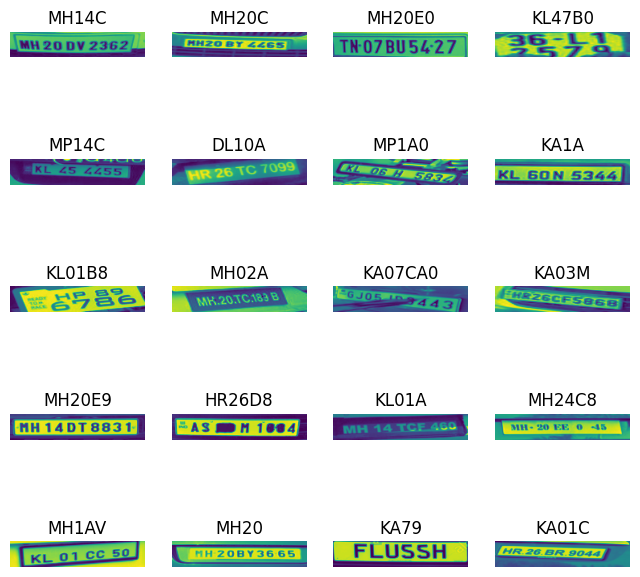

Character Accuracy: 16.37
Word Accuracy: 0.00
 


In [30]:
args['imgdir'] = 'test_images'
args['data'] = CarPlatesDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    args['model'] = model
    #ca, wa = get_accuracy(args)
    ca, wa, recall, precision, labels, predictions = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
    print(" ")
    #print("Recall: ", recall)
    #print("Precision: ", precision)
    #print("Labels:", labels)
    #print(" ")
    #print("Predictions:", predictions)
    
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')